# Probabilistic metrics for GP-LVM and Bayesian GP-LVMs

This notebook introduces the use of a probabilistic geometries approach in the context of Gaussian processes latent variable models, presenting examples of learning a GPLVM and Bayesian GPLVMs on data and show the latent embedding. Especially the magnification factor and what it says about the latent space.

Authors: *Alessandra Tosi, Max Zwiessele*

Note: Requires GPy Version >= 0.8

In [4]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import GPy # import GPy package
np.random.seed(12345)
GPy.plotting.change_plotting_library('plotly')

## Introduction to the visualization tools

We interpret the input space of the GP as a low dimensional $\textit{manifold}$ embedded into a higher dimensional space and we are interested in investigating its geometrical properties. An important aspect of our analysis is the fact that the geometry of the input space is treated in a probabilistic way, consistently with the considered models.

We investigate the form of the $\textit{expected metric}$ of the latent space of GPLVM with exponentiated quadratic kernel. In this notation the output space is denoted with $\mathbf{Y}$ and the input (latent) space with $\mathbf{X}$.

In [2]:
# Define dataset 
N = 100
k1 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,10,10,0.1,0.1]), ARD=True)
k2 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,0.1,10,0.1,10]), ARD=True)
k3 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[0.1,0.1,10,10,10]), ARD=True)
X = np.random.normal(0, 1, (N, 5))
A = np.random.multivariate_normal(np.zeros(N), k1.K(X), 10).T
B = np.random.multivariate_normal(np.zeros(N), k2.K(X), 10).T
C = np.random.multivariate_normal(np.zeros(N), k3.K(X), 10).T

Y = np.vstack((A,B,C))
labels = np.hstack((np.zeros(A.shape[0]), np.ones(B.shape[0]), np.ones(C.shape[0])*2))

input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 

Following from the properties of Gaussian processes (and given that we are using a differentiable kernel) for a test point $\textbf{x}_*$ we can compute the predictive Jacobian $\textbf{J}$ as follows:

$$ \mathbf{J} \sim \prod_p \mathcal{N}( \partial\mathbf{K}_{*,f}\mathbf{K}_{f,f}^{-1}\mathbf{Y}_{:,p}, \partial^2\mathbf{K}_{*,*} - \partial\mathbf{K}_{*,f}\mathbf{K}^{-1}_{f,f}\partial\mathbf{K}_{f,*} ) $$

Given that the distribution of the Jacobian is Gaussian and considering the fact that its $p$ rows are independent,  we compute the $\textit{expected metric tensor}$:

$$ \mathbf{G} = E(\mathbf{J}^T \mathbf{J}) = E(\mathbf{J}^T)E(\mathbf{J}) + d*Cov(\mathbf{J}) $$

For the visualization of the metric tensor we use the square root of its determinant, called the $\textit{magnification factor}$.

###### Predictive metric (including covariance)

The computation of the expected metric tensor $\mathbf{G}$ contains two terms, one related to the mean of the Jacobian $\mathbf{J}$ and one related to its covariance. The plotting tool below allows to separately visualize  the effect of each term. If we use covariance= False, we visualize only the mean and, vice versa, if we use mean = False we plot the effect of the covariance term into the metric.

In [3]:
Q = input_dim
m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,value,constraints,priors
latent_mean,"(300, 2)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,1.0,+ve,


In [9]:
m_gplvm.optimize(messages=1, max_iters=5e4)

In [12]:
figure = GPy.plotting.plotting_library().figure(1, 2, 
                        shared_yaxes=True,
                        shared_xaxes=True,
                        subplot_titles=('Latent Space', 
                                        'Magnification',
                                        )
                            )

canvas = m_gplvm.plot_latent(labels=labels, figure=figure, col=(1), legend=False)
canvas = m_gplvm.plot_magnification(labels=labels, figure=figure, col=(2), legend=False)

GPy.plotting.show(canvas, filename='wishart_metric_notebook')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



In [18]:
figure = GPy.plotting.plotting_library().figure(1, 3, 
                        shared_yaxes=True,
                        shared_xaxes=True,
                        subplot_titles=('Full Magnification', 
                                        'Magnification Mean',
                                        'Magnification Variance'
                                        )
                            )

canvas = m_gplvm.plot_magnification(figure=figure,
                      covariance=True, 
                      updates=False,
                      labels = labels,
                      col=1,
                     )

canvas = m_gplvm.plot_magnification(figure=figure,
                      covariance=False, 
                      updates=False,
                      labels = labels,
                      col=2,
                     )

canvas = m_gplvm.plot_magnification(figure=figure,
                      mean=False,
                      covariance=True, 
                      updates=False,
                      labels = labels,
                      col=3,
                     )

GPy.plotting.show(canvas, filename='wishart_metric_notebook_mean_variance')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]



As you can see, the magnification factor tells us about the 'bending' of the GP embedding. Where there is data, the embedding is dense and bends towards the data. This means the magnification shows us, how the plane got warped (with the data pinned on it) to recreate the latent space. You can see the magnification as stretching and bending. The higher the magnification the more stretched the space is at those places. Still, you need to keep in mind, that the magnification is summarized for all latent dimensions and therefore not always full represents what is going on, as a stretching in one dimension could be counteracted by a contraction of another.

#### Bayesian GPLVM:

We can plot the magnification also for the Bayesian GPLVM. Here it is defined through the inducing inputs, shown as little white triangles in the plot. You can see, that the magnification evolves around the inducing inputs.

In [7]:
GPy.plotting.change_plotting_library('matplotlib')
m = GPy.models.bayesian_gplvm_minibatch.BayesianGPLVMMiniBatch(Y, input_dim, num_inducing=30, missing_data=True)

In [8]:
m.optimize(messages=1, max_iters=5e3)

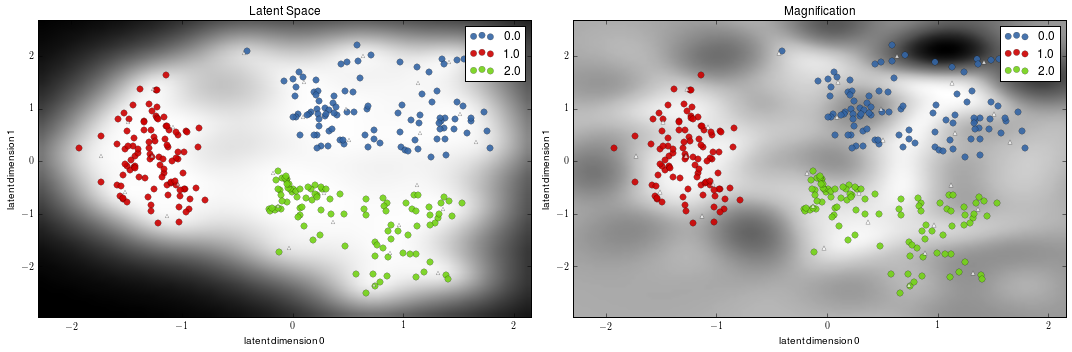

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Latent Space')
v1 = m.plot_latent(labels=labels, ax=axes[0], updates=False)
axes[1].set_title('Magnification')
v2 = m.plot_magnification(labels=labels, ax=axes[1], updates=False, resolution=120)

The magnification factor is less fine grided, as it goes through the inducing inputs, instead of through every data point. Still you can see, the structure of the embedding, being less bent, where there is data and bending towards data. Around the data clusters the magnification (and therefore the embedding) is more flat. Importantly, in the areas far from the data clusters the mean of the embedding is flat, but still the values of the magnification factors show some distortion; this means that out of the data range there is some uncertainty over the structure of the embedding, thanks to the role played by the covariance term.

### Stick demo:
Running the stick demo code and plotting the magnification factor for it:

In [10]:
m_stick = GPy.examples.dimensionality_reduction.stick_bgplvm(plot=False)

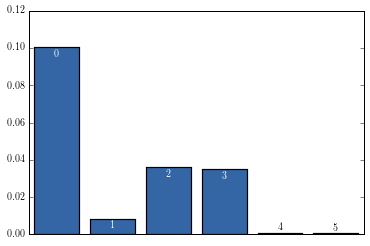

In [11]:
m_stick.kern.plot_ARD()

In [12]:
m.Z.randomize()
m.kern.randomize()
m_stick.optimize(messages=1)

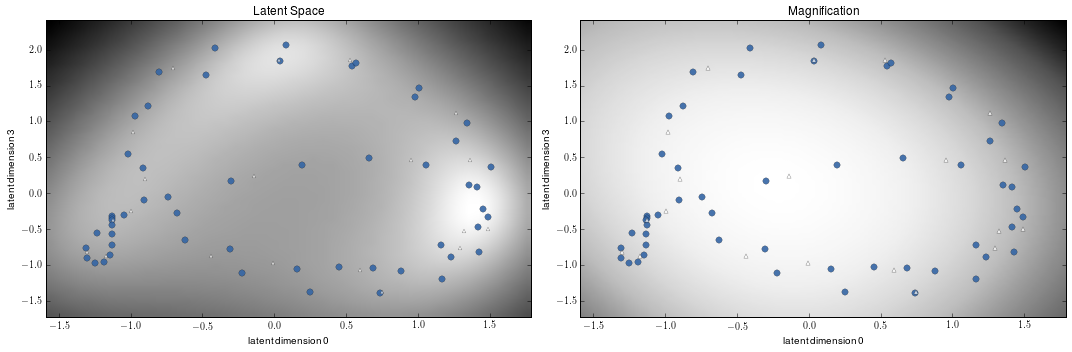

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
wi = [0,3]
axes[0].set_title('Latent Space')
v1 = m_stick.plot_latent(labels=None, ax=axes[0], updates=False, which_indices=wi)
axes[1].set_title('Magnification')
v2 = m_stick.plot_magnification(labels=None, ax=axes[1], updates=False, resolution=120, which_indices=wi)

### Oil Flow Data:
Running the Oil Flow dataset

In [14]:
m_oil = GPy.examples.dimensionality_reduction.bgplvm_oil(N=300, plot=False)

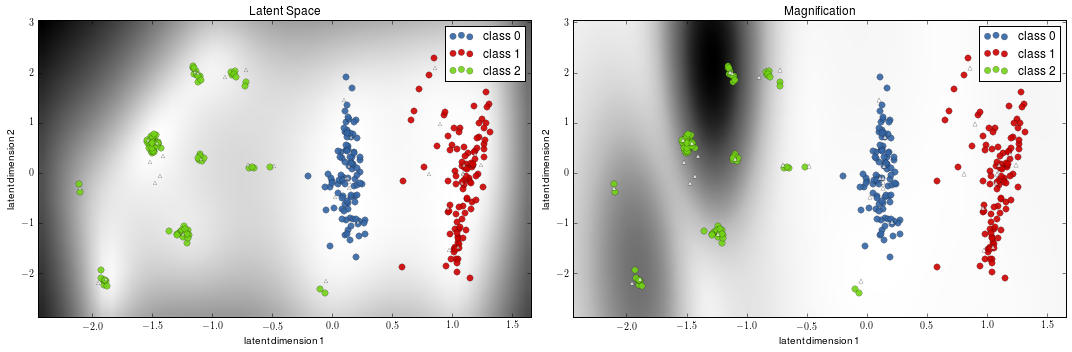

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Latent Space')
v1 = m_oil.plot_latent(labels=m_oil.data_labels, ax=axes[0], updates=False)
axes[1].set_title('Magnification')
v2 = m_oil.plot_magnification(labels=m_oil.data_labels, ax=axes[1], updates=False, resolution=120)

Here  we can see, that in order to seperate class 2 out from the data, the BayesianGPLVM needed to stretch thin and the manifold is bent around class 2 the most, whereas it did not have to bend as much to seperate class 0 and 1. 